In [55]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping
import csv
import openpyxl
import tensorflow as tf

# **Common Functions**

In [39]:
def plot_predictions(od, all_predictions, all=False):
    plt.figure()
    plt.title('S&P Price Predictions')
    plt.xlabel('Trading Date')
    plt.ylabel('S&P Price')
    if(all):
        plt.plot(od['Date'],od['Close'],color = 'lightblue', label = 'Org Price')        
        plt.plot(od['Date'],all_predictions, color = 'chocolate', label = 'Predicted Price')      

    else:
        plt.plot(od['Date'],od['Close'], color = 'lightblue', label = 'Org Price')
        plt.plot(od['Date'].values[:all_predictions.shape[0]],all_predictions, color = 'chocolate', label = 'Predicted Price')    
    plt.legend()
    plt.show()

# **Loading Dataset**

In [40]:
data = pd.read_csv('./S&P500.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,S&P 500 PE Ratio
0,2021-12-31,4775.21,4786.83,4765.75,4766.18,4766.18,2446190000,30.02
1,2021-12-30,4794.23,4808.93,4775.33,4778.73,4778.73,2390990000,29.72
2,2021-12-29,4788.64,4804.06,4778.08,4793.06,4793.06,2369370000,29.42
3,2021-12-28,4795.49,4807.02,4780.04,4786.35,4786.35,2217050000,29.12
4,2021-12-27,4733.99,4791.49,4733.99,4791.19,4791.19,2264120000,28.82


# **Overlay of the Schiller P/E onto S&P500**

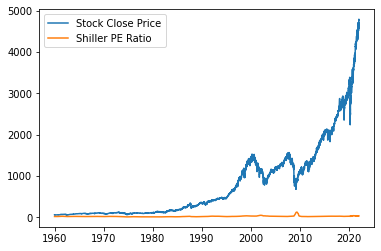

In [41]:
plt.figure()
plt.plot(data['Date'],data['Close'],label='Stock Close Price')
plt.plot(data['Date'],data['S&P 500 PE Ratio'],label='Shiller PE Ratio')
plt.legend()

In [68]:
split = 1510
input_data = []
output_data = []
rows_count = data.shape[0]
sampling_window = 180

translated_data = MinMaxScaler(feature_range = (0, 1)).fit(data[['Close']].values)
print(translated_data.transform(data[['Close']].values))
normalized_data = translated_data.transform(data[['Close']].values)
normalized_data[0:5]

for i in range(sampling_window,rows_count,1):
  input_data.append(normalized_data[i-sampling_window:i])
  output_data.append(normalized_data[i])
  
input_data=np.array(input_data)
output_data=np.array(output_data)
input_data=input_data.reshape(input_data.shape[0],input_data.shape[1], 1)
output_data=output_data.reshape(output_data.shape[0], 1)

#selecting random test data
X_train=input_data[:-split]
X_test=input_data[-split:]
y_train=output_data[:-split]
y_test=output_data[-split:]
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

[[0.99433014]
 [1.        ]
 [0.99858464]
 ...
 [0.00167269]
 [0.00172753]
 [0.00162629]]
(13916, 180, 1) (13916, 1) (1510, 180, 1) (1510, 1)



# **Unoptimized model**
## epochs=1 

In [43]:
# Creating the model
model = Sequential()
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

model.compile(loss = 'mean_squared_error', metrics=[tf.keras.metrics.Accuracy()])
model.summary()

# Fitting the model
model.fit(X_train, y_train, epochs =1,batch_size=32)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 180, 50)           10400     
_________________________________________________________________
dropout_8 (Dropout)          (None, 180, 50)           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 180, 50)           20200     
_________________________________________________________________
dropout_9 (Dropout)          (None, 180, 50)           0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 180, 50)           20200     
_________________________________________________________________
dropout_10 (Dropout)         (None, 180, 50)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 50)               

# **Prediciting all years**

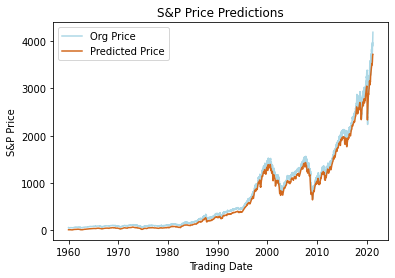

In [44]:
predictions_train = model.predict(X_train)
predictions_train = translated_data.inverse_transform(predictions_train)

predictions_test = model.predict(X_test)
predictions_test=translated_data.inverse_transform(predictions_test)
 
all_predictions=np.append(predictions_train, predictions_test)
original_data=data[X_train.shape[1]:]

# plotting data
plot_predictions(original_data, all_predictions, True)

# **Predictions for a particular set of years**

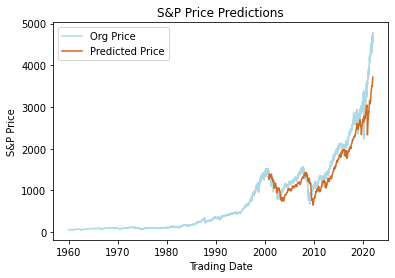

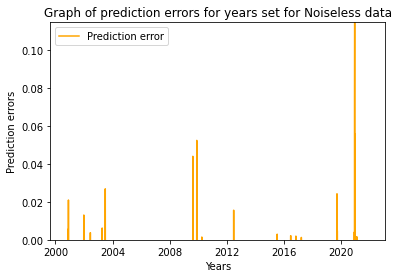

Prediction error [[-0.11146064]
 [-0.10829235]
 [-0.09848458]
 ...
 [-0.09019047]
 [-0.09834742]
 [-0.09509103]]
Accuracy: 92.34212204065743


In [45]:
data1=[]
data2=[]
pred_2000 = np.array(data['Close'].values[:5538])
pred_2000 = translated_data.transform(pred_2000.reshape(-1,1))
for i in range(sampling_window,5538,1):
  data1.append(pred_2000[i-sampling_window:i])
  data2.append(pred_2000[i])
data1 = np.array(data1)
data1=data1.reshape(data1.shape[0],data1.shape[1], 1)

predictions_2000 = model.predict(data1)
predictions_2000 = translated_data.inverse_transform(predictions_2000)
 
original_data=data2
original_data=translated_data.inverse_transform(data2)

# plotting data
plot_predictions(data, predictions_2000)
 
# Predicting accuracy
prediction_error = (predictions_2000-original_data)/(original_data)
plt.figure()
plt.plot(data['Date'].values[:predictions_2000.shape[0]],prediction_error, color = 'orange', label = 'Prediction error')
plt.ylim((0,max(prediction_error)))
plt.title('Graph of prediction errors for years set for Noiseless data')
plt.xlabel('Years')
plt.ylabel('Prediction errors')
plt.legend()
plt.show()


print('Prediction error', prediction_error)
print('Accuracy:', 100 - (100*(abs(original_data-predictions_2000)/original_data)).mean())

# **Predicting with 5 epochs**

Epoch 1/5
435/435 [==============================] - 127s 291ms/step - loss: 9.4190e-04 - accuracy: 0.0000e+00
Epoch 2/5
435/435 [==============================] - 121s 279ms/step - loss: 7.7374e-04 - accuracy: 0.0000e+00
Epoch 3/5
435/435 [==============================] - 111s 256ms/step - loss: 7.0476e-04 - accuracy: 0.0000e+00
Epoch 4/5
435/435 [==============================] - 110s 253ms/step - loss: 6.2153e-04 - accuracy: 0.0000e+00
Epoch 5/5
435/435 [==============================] - 111s 255ms/step - loss: 6.1013e-04 - accuracy: 0.0000e+00


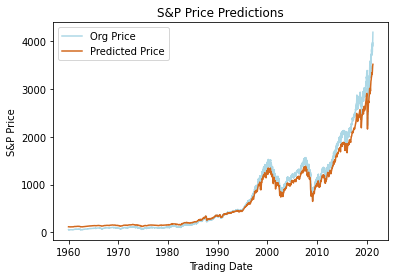

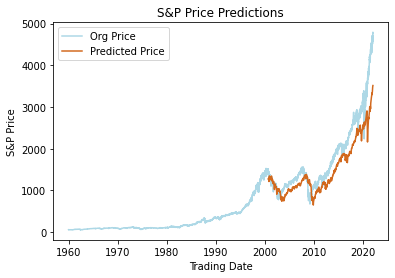

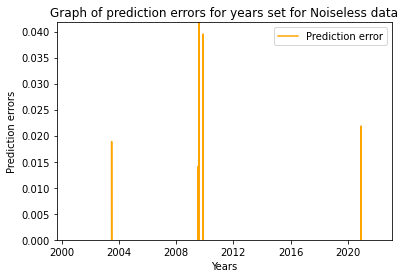

Prediction error [[-0.16021725]
 [-0.15752306]
 [-0.14843893]
 ...
 [-0.11871638]
 [-0.12956718]
 [-0.12777054]]
Accuracy: 89.32334791375574


In [46]:
model.fit(X_train, y_train, epochs =5,batch_size=32)

predictions_train = model.predict(X_train)
predictions_train = translated_data.inverse_transform(predictions_train)

predictions_test = model.predict(X_test)
predictions_test=translated_data.inverse_transform(predictions_test)
 
all_predictions=np.append(predictions_train, predictions_test)
original_data=data[X_train.shape[1]:]

# plotting data
plot_predictions(original_data, all_predictions, True)



data1=[]
data2=[]
pred_2000 = np.array(data['Close'].values[:5538])
pred_2000 = translated_data.transform(pred_2000.reshape(-1,1))
for i in range(sampling_window,5538,1):
  data1.append(pred_2000[i-sampling_window:i])
  data2.append(pred_2000[i])
data1 = np.array(data1)
data1=data1.reshape(data1.shape[0],data1.shape[1], 1)

predictions_2000 = model.predict(data1)
predictions_2000 = translated_data.inverse_transform(predictions_2000)
 
original_data=data2
original_data=translated_data.inverse_transform(data2)

# plotting data
plot_predictions(data, predictions_2000)
 
# Predicting accuracy
prediction_error = (predictions_2000-original_data)/(original_data)
plt.figure()
plt.plot(data['Date'].values[:predictions_2000.shape[0]],prediction_error, color = 'orange', label = 'Prediction error')
plt.ylim((0,max(prediction_error)))
plt.title('Graph of prediction errors for years set for Noiseless data')
plt.xlabel('Years')
plt.ylabel('Prediction errors')
plt.legend()
plt.show()


print('Prediction error', prediction_error)
print('Accuracy:', 100 - (100*(abs(original_data-predictions_2000)/original_data)).mean())

# **Optimized model**
# epochs=1

In [47]:
# Creating the model

model = Sequential()
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=[tf.keras.metrics.Accuracy()])
model.summary()
model.fit(X_train, y_train, epochs =1,batch_size=32)


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 180, 50)           10400     
_________________________________________________________________
dropout_12 (Dropout)         (None, 180, 50)           0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 180, 50)           20200     
_________________________________________________________________
dropout_13 (Dropout)         (None, 180, 50)           0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 180, 50)           20200     
_________________________________________________________________
dropout_14 (Dropout)         (None, 180, 50)           0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 50)               

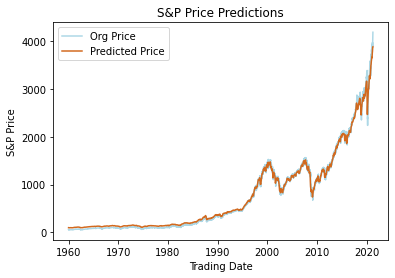

In [48]:
predictions_train = model.predict(X_train)
predictions_train = translated_data.inverse_transform(predictions_train)

predictions_test = model.predict(X_test)
predictions_test=translated_data.inverse_transform(predictions_test)
 
all_predictions=np.append(predictions_train, predictions_test)
original_data=data[X_train.shape[1]:]

# plotting data
plot_predictions(original_data, all_predictions, True)

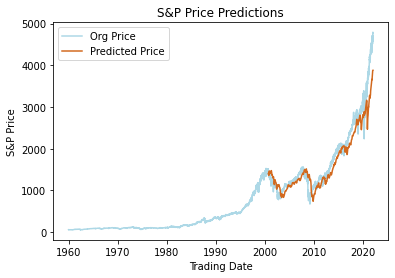

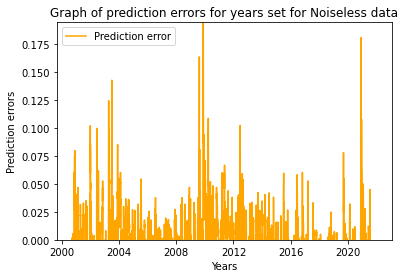

Prediction error [[-0.07255279]
 [-0.06916828]
 [-0.05883945]
 ...
 [-0.03523148]
 [-0.04337096]
 [-0.03936506]]
Accuracy: 97.37827780803629


In [49]:
data1=[]
data2=[]
pred_2000 = np.array(data['Close'].values[:5538])
pred_2000 = translated_data.transform(pred_2000.reshape(-1,1))
for i in range(sampling_window,5538,1):
  data1.append(pred_2000[i-sampling_window:i])
  data2.append(pred_2000[i])
data1 = np.array(data1)
data1=data1.reshape(data1.shape[0],data1.shape[1], 1)

predictions_2000 = model.predict(data1)
predictions_2000 = translated_data.inverse_transform(predictions_2000)
 
original_data=data2
original_data=translated_data.inverse_transform(data2)

# plotting data
plot_predictions(data, predictions_2000)
 
# Predicting accuracy
prediction_error = (predictions_2000-original_data)/(original_data)
plt.figure()
plt.plot(data['Date'].values[:predictions_2000.shape[0]],prediction_error, color = 'orange', label = 'Prediction error')
plt.ylim((0,max(prediction_error)))
plt.title('Graph of prediction errors for years set for Noiseless data')
plt.xlabel('Years')
plt.ylabel('Prediction errors')
plt.legend()
plt.show()


print('Prediction error', prediction_error)
print('Accuracy:', 100 - (100*(abs(original_data-predictions_2000)/original_data)).mean())

# **Prediciting with 5 epochs**

Epoch 1/5
435/435 [==============================] - 112s 258ms/step - loss: 5.1109e-04 - accuracy: 0.0000e+00
Epoch 2/5
435/435 [==============================] - 105s 241ms/step - loss: 4.6861e-04 - accuracy: 0.0000e+00
Epoch 3/5
435/435 [==============================] - 105s 242ms/step - loss: 3.9007e-04 - accuracy: 0.0000e+00
Epoch 4/5
435/435 [==============================] - 108s 249ms/step - loss: 3.9297e-04 - accuracy: 0.0000e+00
Epoch 5/5
435/435 [==============================] - 106s 244ms/step - loss: 3.4015e-04 - accuracy: 0.0000e+00


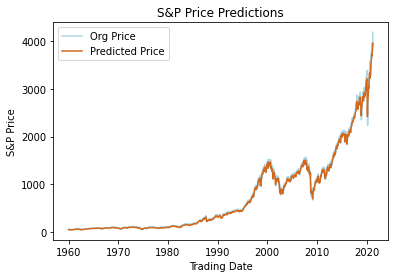

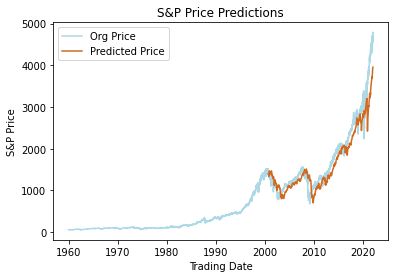

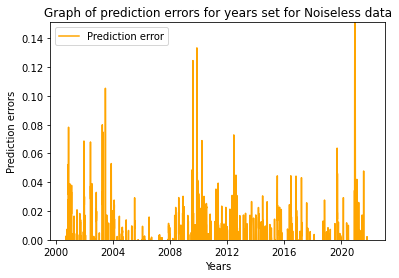

Prediction error [[-0.05482947]
 [-0.05169379]
 [-0.0414668 ]
 ...
 [-0.03577346]
 [-0.04533555]
 [-0.04261923]]
Accuracy: 97.30167001770751


In [50]:
model.fit(X_train, y_train, epochs =5,batch_size=32)

predictions_train = model.predict(X_train)
predictions_train = translated_data.inverse_transform(predictions_train)

predictions_test = model.predict(X_test)
predictions_test=translated_data.inverse_transform(predictions_test)
 
all_predictions=np.append(predictions_train, predictions_test)
original_data=data[X_train.shape[1]:]

# plotting data
plot_predictions(original_data, all_predictions, True)



data1=[]
data2=[]
pred_2000 = np.array(data['Close'].values[:5538])
pred_2000 = translated_data.transform(pred_2000.reshape(-1,1))
for i in range(sampling_window,5538,1):
  data1.append(pred_2000[i-sampling_window:i])
  data2.append(pred_2000[i])
data1 = np.array(data1)
data1=data1.reshape(data1.shape[0],data1.shape[1], 1)

predictions_2000 = model.predict(data1)
predictions_2000 = translated_data.inverse_transform(predictions_2000)
 
original_data=data2
original_data=translated_data.inverse_transform(data2)

# plotting data
plot_predictions(data, predictions_2000)
 
# Predicting accuracy
prediction_error = (predictions_2000-original_data)/(original_data)
plt.figure()
plt.plot(data['Date'].values[:predictions_2000.shape[0]],prediction_error, color = 'orange', label = 'Prediction error')
plt.ylim((0,max(prediction_error)))
plt.title('Graph of prediction errors for years set for Noiseless data')
plt.xlabel('Years')
plt.ylabel('Prediction errors')
plt.legend()
plt.show()


print('Prediction error', prediction_error)
print('Accuracy:', 100 - (100*(abs(original_data-predictions_2000)/original_data)).mean())

# **Adding Noise to data**

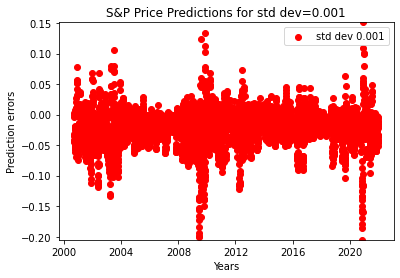

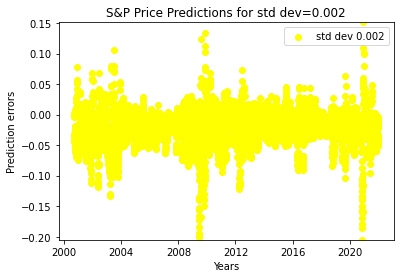

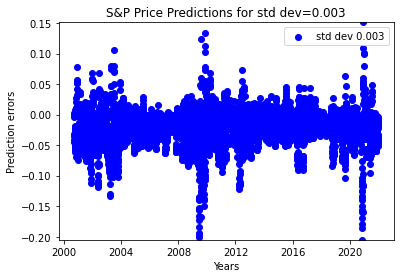

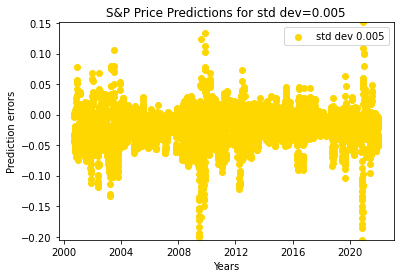

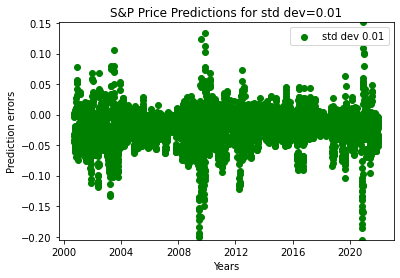

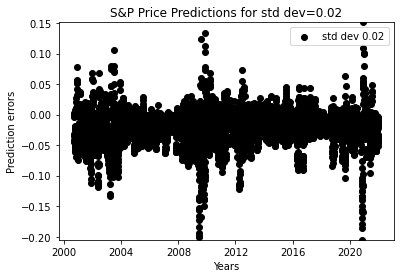

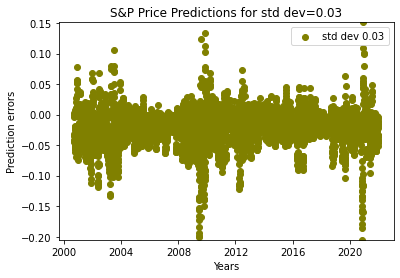

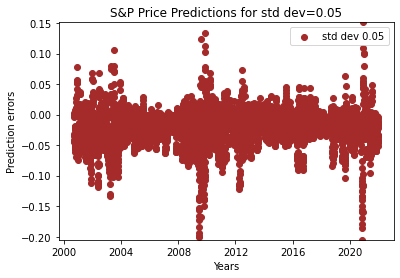

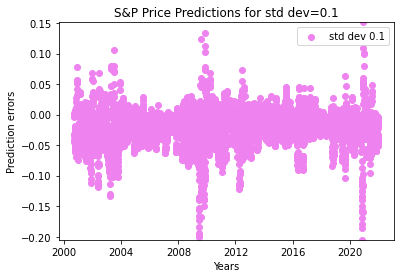

In [51]:
dates = data["Date"].tolist()
data.drop(columns=["Date"], index=1, inplace=True)
noisy_0_001 = pd.DataFrame(data) 
noisy_0_002 = pd.DataFrame(data) 
noisy_0_003 = pd.DataFrame(data) 
noisy_0_005 = pd.DataFrame(data) 
noisy_0_01 = pd.DataFrame(data) 
noisy_0_02 = pd.DataFrame(data) 
noisy_0_03 = pd.DataFrame(data) 
noisy_0_05 = pd.DataFrame(data) 
noisy_0_1 = pd.DataFrame(data)

def noisy_data(data, i, stddev):
    import random
    random.seed(i)
    rand_value = random.sample(range(0,1510), 144)
    for  index, r in data.loc[rand_value].iterrows():
        noise= np.random.normal(0, stddev)
        r=r+noise
def generate_noisy_data(data):
    data1=[]
    data2=[]
    pred_2000 = np.array(data['Close'].values[:5538])
    pred_2000 = translated_data.transform(pred_2000.reshape(-1,1))
    for i in range(sampling_window,5538,1):
        data1.append(pred_2000[i-sampling_window:i])
        data2.append(pred_2000[i])
    data1 = np.array(data1)
    data1=data1.reshape(data1.shape[0],data1.shape[1], 1)

    predictions_2000 = model.predict(data1)
    predictions_2000 = translated_data.inverse_transform(predictions_2000)
    original_data=data2
    original_data=translated_data.inverse_transform(data2)

    pe = (predictions_2000 - original_data) / (original_data)
    return predictions_2000, pe

def generate_noisy_graph(data, predicted_data, pe, stddev):
    colors = {
        0.001: 'red',
        0.002: 'yellow',
        0.003: 'blue',
        0.005: 'gold',
        0.01: 'green',
        0.02: 'black',
        0.03: 'olive',
        0.05: 'brown',
        0.1: 'violet'
    }
    plt.scatter(data['Date'].values[:predicted_data.shape[0]],pe, color = colors[stddev], label = f"std dev {stddev}")
    plt.ylim((min(pe),max(pe)))
    plt.title(f"S&P Price Predictions for std dev={stddev}")
    plt.xlabel('Years')
    plt.ylabel('Prediction errors')
    plt.legend()
    plt.show()
#--------------------------------Adding noise for std dev 0.001-----------------------------
noisy_data(noisy_0_001, 1, 0.001)

#--------------------------------Adding noise for std dev 0.002-----------------------------
noisy_data(noisy_0_002, 2, 0.002)

 #-------------------------------Adding noise for std dev 0.003----------------------------
noisy_data(noisy_0_003, 3, 0.003)

#---------------------------Adding noise for std dev 0.005-------------------------------
noisy_data(noisy_0_005, 4, 0.005)

#-----------------------------Adding noise for std dev 0.01--------------------------
noisy_data(noisy_0_01, 5, 0.01)

#-----------------------------Adding noise for std dev 0.02--------------------------
noisy_data(noisy_0_02, 6, 0.02)

#-----------------------------Adding noise for std dev 0.03--------------------------
noisy_data(noisy_0_03, 7, 0.03)

#-----------------------------Adding noise for std dev 0.05--------------------------
noisy_data(noisy_0_05, 8, 0.05)

#-----------------------------Adding noise for std dev 0.1--------------------------
noisy_data(noisy_0_1, 0, 0.1)
        
noisy_0_001['Date'] = pd.Series(dates)
noisy_0_002['Date'] = pd.Series(dates)
noisy_0_003['Date'] = pd.Series(dates)
noisy_0_005['Date'] = pd.Series(dates)
noisy_0_01['Date'] = pd.Series(dates)
noisy_0_02['Date'] = pd.Series(dates)
noisy_0_03['Date'] = pd.Series(dates)
noisy_0_05['Date'] = pd.Series(dates)
noisy_0_1['Date'] = pd.Series(dates)

pred_0_001, pe_0_001 = generate_noisy_data(noisy_0_001)
pred_0_002, pe_0_002 = generate_noisy_data(noisy_0_002)
pred_0_003, pe_0_003 = generate_noisy_data(noisy_0_003)
pred_0_005, pe_0_005 = generate_noisy_data(noisy_0_005)
pred_0_01, pe_0_01 = generate_noisy_data(noisy_0_01)
pred_0_02, pe_0_02 = generate_noisy_data(noisy_0_02)
pred_0_03, pe_0_03 = generate_noisy_data(noisy_0_03)
pred_0_05, pe_0_05 = generate_noisy_data(noisy_0_05)
pred_0_1, pe_0_1 = generate_noisy_data(noisy_0_1)

generate_noisy_graph(noisy_0_001, pred_0_001, pe_0_001, 0.001)
generate_noisy_graph(noisy_0_002, pred_0_002, pe_0_002, 0.002)
generate_noisy_graph(noisy_0_003, pred_0_003, pe_0_003, 0.003)
generate_noisy_graph(noisy_0_005, pred_0_005, pe_0_005, 0.005)
generate_noisy_graph(noisy_0_01, pred_0_01, pe_0_01, 0.01)
generate_noisy_graph(noisy_0_02, pred_0_02, pe_0_02, 0.02)
generate_noisy_graph(noisy_0_03, pred_0_03, pe_0_03, 0.03)
generate_noisy_graph(noisy_0_05, pred_0_05, pe_0_05, 0.05)
generate_noisy_graph(noisy_0_1, pred_0_1, pe_0_1, 0.1)


In [52]:
final_noisy_data = { 
    0.001: pe_0_001.tolist(), 
    0.002: pe_0_002.tolist(), 
    0.003: pe_0_003.tolist(), 
    0.005: pe_0_005.tolist(), 
    0.01: pe_0_01.tolist(), 
    0.02: pe_0_02.tolist(),
    0.03: pe_0_03.tolist(), 
    0.05: pe_0_05.tolist(), 
    0.1: pe_0_1.tolist()
}
df = pd.DataFrame(data=final_noisy_data)
pd.set_option('display.max_columns', None)
print(df)

                        0.001                    0.002  \
0      [-0.05169384356072052]   [-0.05169384356072052]   
1      [-0.04146680328651328]   [-0.04146680328651328]   
2      [-0.04572864924008657]   [-0.04572864924008657]   
3       [-0.0429997881081349]    [-0.0429997881081349]   
4      [-0.04369180550341508]   [-0.04369180550341508]   
...                       ...                      ...   
5353  [0.0025104010724085173]  [0.0025104010724085173]   
5354   [-0.03577346163187527]   [-0.03577346163187527]   
5355  [-0.045335547340267145]  [-0.045335547340267145]   
5356   [-0.04261922748716261]   [-0.04261922748716261]   
5357   [-0.04206467931199864]   [-0.04206467931199864]   

                        0.003                    0.005  \
0      [-0.05169384356072052]   [-0.05169384356072052]   
1      [-0.04146680328651328]   [-0.04146680328651328]   
2      [-0.04572864924008657]   [-0.04572864924008657]   
3       [-0.0429997881081349]    [-0.0429997881081349]   
4      [-0.04

In [58]:
# with pd.ExcelWriter('output.xlsx') as writer:  
#     df.to_excel(writer, sheet_name='Sheet_name_1')

# **Extra Credit - Adding Schiller PE Ratio to adjust Predictions**

In [110]:
extra_dataset = data[['Close', 'S&P 500 PE Ratio']].values
extra_dataset

array([[4766.18      ,   30.02      ],
       [4793.06      ,   29.42      ],
       [4786.35      ,   29.12      ],
       ...,
       [  60.13      ,   17.01193548],
       [  60.39      ,   17.03354839],
       [  59.91      ,   17.05516129]])

In [ ]:
def setPEratio(pe_ratio):
    pe = 0
    if pe_ratio < 7.5:
        pe = 5
    elif pe_ratio >= 7.5 and pe_ratio < 12.75:
        pe = 4
    elif pe_ratio >= 12.75 and pe_ratio < 15:
        pe = 3
    elif pe_ratio >= 15 and pe_ratio < 20:
        pe = 2
    elif pe_ratio >= 20 and pe_ratio < 25:
        pe = 1
    elif pe_ratio >= 25:
        pe = 0
    return pe

extra_dataset = np.append(extra_dataset,np.zeros([len(extra_dataset),1]),1)
for x in extra_dataset:
    s = setPEratio(x[1])
    x[2] = s

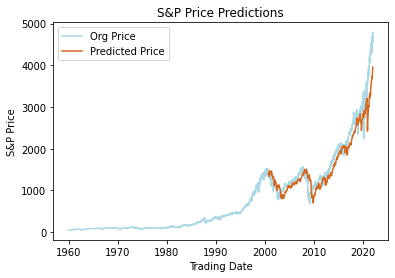

In [112]:
sc = MinMaxScaler(feature_range = (0, 1))
dataset_scaled = sc.fit(extra_dataset[:,:1])

data1=[]
data2=[]
pred_2000 = np.array(data['Close'].values[:5538])
pred_2000 = dataset_scaled.transform(pred_2000.reshape(-1,1))
for i in range(sampling_window,5538,1):
  data1.append(pred_2000[i-sampling_window:i])
  data2.append(pred_2000[i])
data1 = np.array(data1)
data1=data1.reshape(data1.shape[0],data1.shape[1], 1)

predictions_2000 = model.predict(data1)
predictions_2000 = dataset_scaled.inverse_transform(predictions_2000)
original_data=data2
original_data=dataset_scaled.inverse_transform(data2)

# plotting data
plot_predictions(data, predictions_2000)
